# Figure S3 (Supplementary material)
### Visualization of the monthly Pb boundary conditions at the Labrador Sea boundary

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cmocean
from math import sin, cos, sqrt, atan2, radians
import xarray as xr
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from constants import imin, imax, jmin, jmax, isize, jsize, \
                      rimwidthN, rimwidthS, rimwidthW, rimwidthE, \
                      bdy_NCB, bdy_WCB, bdy_LS, bdy_HB, \
                      path_figure, land_color

%matplotlib inline

#### Files

In [3]:
# The Pb model configuration ANHA12 mask:
mask         = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20230213.nc')
mesh_lon     = mask['nav_lon'].values
mesh_lat     = mask['nav_lat'].values
mesh_bathy   = mask['tmask'].values[0,:,:,:]
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
ocean_masked = np.ma.masked_where((mesh_bathy<0.1), mesh_bathy)
depths       = mask['nav_lev'].values

In [4]:
# ANHA12 grid mesh:
mesh        = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
mesh_hdept  = mesh['hdept'].values[0,:,:]
mesh_hdepw  = mesh['hdepw'].values[0,:,:]
mesh_mbathy = mesh['mbathy'].values[0,:,:]
mesh_gdepw  = mesh['gdepw_1d'].values[0,:]

In [5]:
# Boundary condition file for grid coordinates (created with notebook forcing/create-TS-based-BCs.ipynb)
BC     = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/Pb-forcing-202311/bdy-reference/Pb_OBC_y2002m01.nc')
dPb_S  = BC.dPb_S.values.reshape(50,rimwidthS,bdy_LS[3]-bdy_LS[2])
dPb_N  = BC.dPb_N.values.reshape(50,rimwidthN,bdy_WCB[3]-bdy_WCB[2])
dPb_E  = BC.dPb_E.values.reshape(50,rimwidthE,bdy_NCB[1]-bdy_NCB[0])
dPb_W  = BC.dPb_W.values.reshape(50,rimwidthW,bdy_HB[1]-bdy_HB[0])

# Labrador Sea
dPb_S_lons = mesh_lon[bdy_LS[0]:bdy_LS[1],bdy_LS[2]:bdy_LS[3]] 
dPb_S_lats = mesh_lat[bdy_LS[0]:bdy_LS[1],bdy_LS[2]:bdy_LS[3]]
dPb_S_mdepths = bathy_masked[:,bdy_LS[0]:bdy_LS[1],bdy_LS[2]:bdy_LS[3]]

# Northern Canada Basin
dPb_E_lons = mesh_lon[bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]:bdy_NCB[3]] 
dPb_E_lats = mesh_lat[bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]:bdy_NCB[3]] 
dPb_E_mdepths = bathy_masked[:,bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]:bdy_NCB[3]] 

# Western Canada Basin
dPb_N_lons = mesh_lon[bdy_WCB[0]:bdy_WCB[1],bdy_WCB[2]:bdy_WCB[3]] 
dPb_N_lats = mesh_lat[bdy_WCB[0]:bdy_WCB[1],bdy_WCB[2]:bdy_WCB[3]]
dPb_N_mdepths = bathy_masked[:,bdy_WCB[0]:bdy_WCB[1],bdy_WCB[2]:bdy_WCB[3]]

# Hudson Bay
dPb_W_lons = mesh_lon[bdy_HB[0]:bdy_HB[1],bdy_HB[2]:bdy_HB[3]] 
dPb_W_lats = mesh_lat[bdy_HB[0]:bdy_HB[1],bdy_HB[2]:bdy_HB[3]] 
dPb_W_mdepths = bathy_masked[:,bdy_HB[0]:bdy_HB[1],bdy_HB[2]:bdy_HB[3]] 

BC.close()

Load multi-month boundaries:

In [6]:
dPb_S_monthly = np.empty((12,50,10,226))

# Load dissolved Pb concentrations in the Labrador Sea boundary for each month in 2015:
for month in range(1,13):
    BC     = xr.open_dataset(f'/ocean/brogalla/GEOTRACES/data/Pb-forcing-202311/bdy-reference/Pb_OBC_y2015m{month:02}.nc')
    dPb_S_monthly[month-1,:,:,:] = BC.dPb_S.values.reshape(50,10,226)
    BC.close()

#### Functions

In [7]:
# Convert lat/lon to distance along transect:
def calc_distance(lats, lons):
    R = 6373.0 # approximate radius of earth in km

    lats_rad = [radians(l) for l in lats]
    lons_rad = [radians(l) for l in lons]

    dlon = [lon_step - lons_rad[0] for lon_step in lons_rad]
    dlat = [lat_step - lats_rad[0] for lat_step in lats_rad]

    distance = np.empty((len(dlon)))
    for i in range(0,len(dlon)):
        a = sin(dlat[i] / 2)**2 + cos(lats_rad[0]) * cos(lats_rad[i]) * sin(dlon[i] / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance[i] = R * c
        
    return distance

In [8]:
def get_boundary_depths(bdy_distance, bdy_ind, cell=0):
    # get the depths associated with the cells in the transect
    
    model_depths    = np.zeros((len(depths), len(bdy_distance)))
    for n in range(0,len(bdy_distance)): 
        mesh_depth_adjusted = np.copy(mesh_gdepw)
        if (bdy_ind[1]-bdy_ind[0]) < (bdy_ind[3]-bdy_ind[2]): # depending on orientation of boundary
            bathy_ind           = mesh_mbathy[bdy_ind[0]+cell, bdy_ind[2]+n]
            mesh_depth_adjusted[0:int(bathy_ind)]  = mesh_hdepw[bdy_ind[0]+cell, bdy_ind[2]+n]
        else:
            bathy_ind           = mesh_mbathy[bdy_ind[0]+n, bdy_ind[2]+cell]
            mesh_depth_adjusted[0:int(bathy_ind)]  = mesh_hdepw[bdy_ind[0]+n, bdy_ind[2]+cell]

        model_depths[:,n]    = mesh_depth_adjusted
    
    return model_depths

In [9]:
def plot_transect(ax, variable, vrange=(30,35), label='', cmap=cmocean.cm.deep, labelling=True, bdy_cell=0):
    # Function to visualize a variable at the Labrador Sea cross section on specified axis
    
    ax.invert_yaxis()
    ax.set_ylim(3500, 0)
    ax.set_xlim(0, 1100)
    ax.tick_params(axis='both', which='major', labelsize=8)
    
    # plot model boundary condition:
    xx, zz = np.meshgrid(S_distance, mesh_gdepw)
    CB1 = ax.pcolormesh(xx, zz, variable[:,bdy_cell,:], vmin=vrange[0], vmax=vrange[1], cmap=cmap)
    ax.pcolormesh(xx, S_model_depths, variable[:,bdy_cell,:], cmap=matplotlib.colors.ListedColormap([land_color]), alpha=1)
    
    return CB1

In [10]:
def land_patch(distances, coordi, coordj):
    # Function creates a patch to mask land in the transect plots
    topo = []
    for d, distance in enumerate(distances[0:-1]):
        rect = Rectangle((distance, mesh_hdepw[coordi,coordj+d]), distances[d+1]-distance, 5000)
        topo.append(rect)

    pc = PatchCollection(topo, facecolors=land_color, edgecolors=land_color, alpha=1)
    return pc

#### Calculations

In [11]:
bdy_cell = 5 # show slices from the middle of the boundary

# Look at only one slice of the rimwidth thickness boundary:
S_distance  = calc_distance(dPb_S_lats[bdy_cell,:]   , dPb_S_lons[bdy_cell,:])    # Labrador Sea

S_model_depths = get_boundary_depths(S_distance, bdy_LS,  cell=bdy_cell)

#### Figures

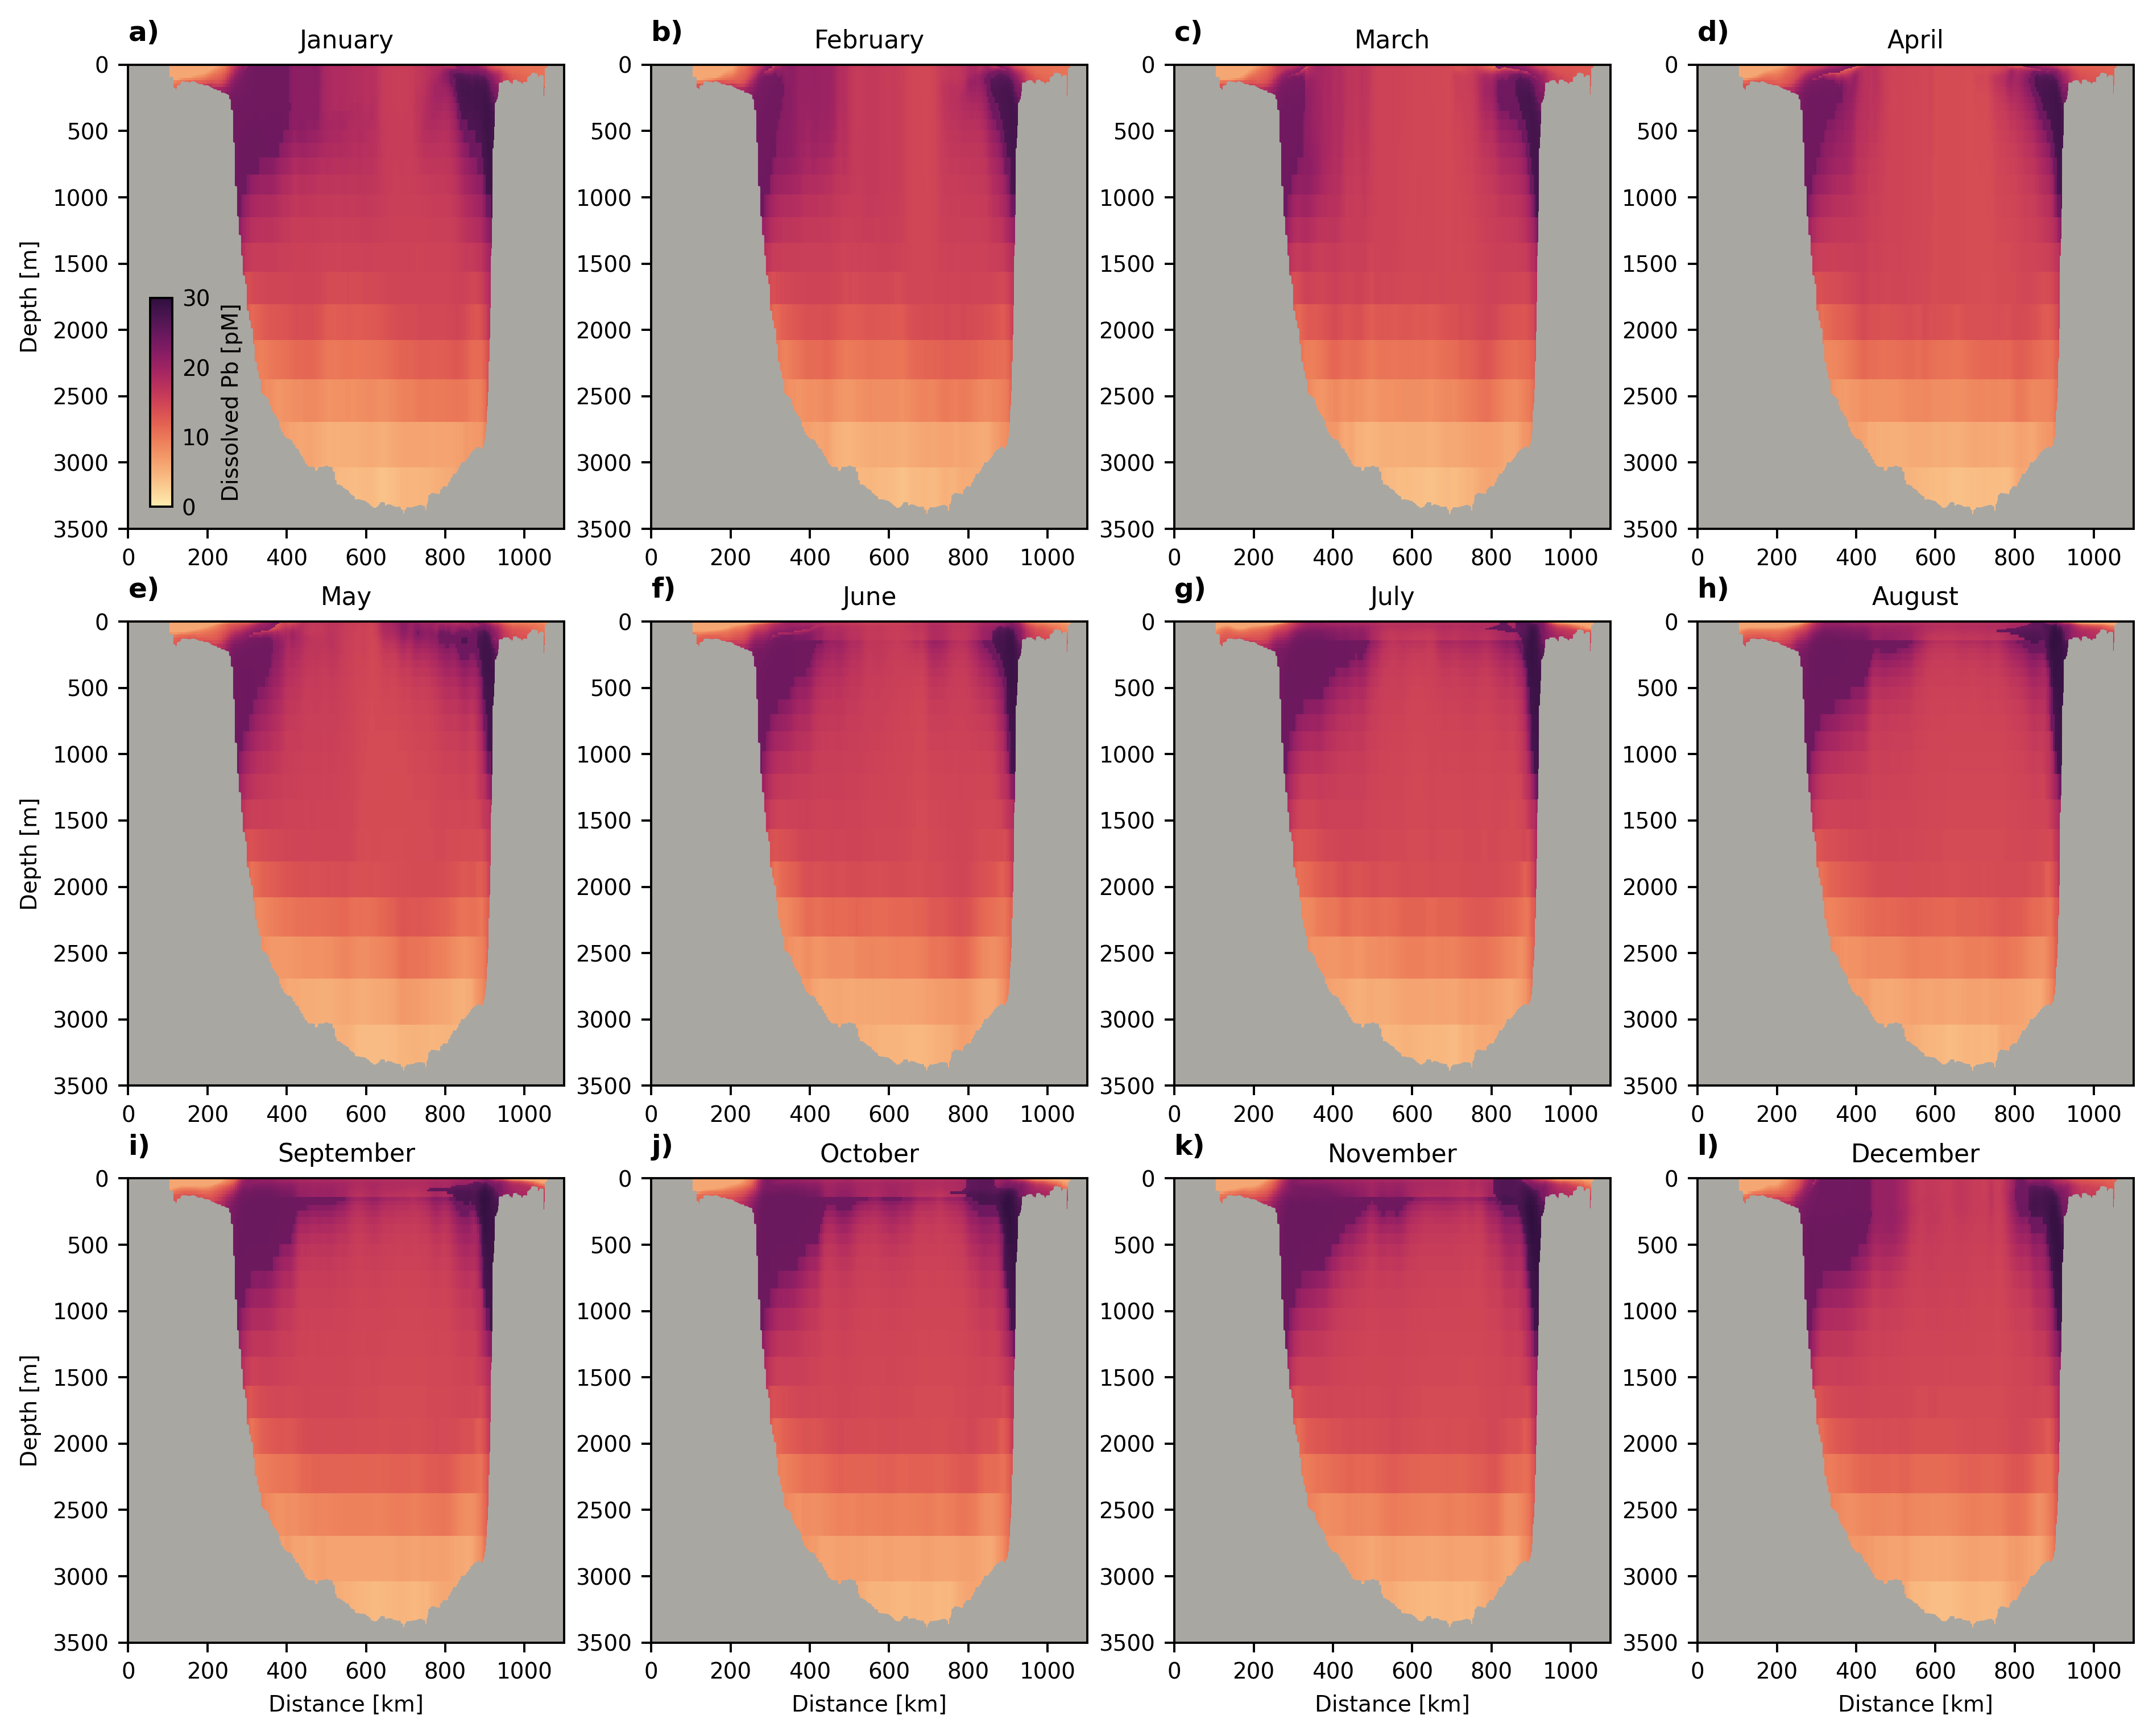

In [12]:
fig, ax = plt.subplots(3,4, figsize=(13, 10.5), dpi=350)

axes = ax.ravel()
months=['January','February', 'March','April','May','June','July','August','September','October','November','December']
labels=['a)','b)','c)','d)','e)','f)', 'g)', 'h)', 'i)', 'j)', 'k)', 'l)']

for month in range(0,12):
    CB1 = plot_transect(axes[month], dPb_S_monthly[month,:,:,:]*1e12, vrange=(0,30), label='', \
                        cmap=cmocean.cm.matter, labelling=False, bdy_cell=bdy_cell)
        
    LS_patch = land_patch(S_distance, bdy_LS[0]+bdy_cell, bdy_LS[2])
    axes[month].add_collection(LS_patch)
    axes[month].set_title(f'{months[month]}', fontsize=9)
    axes[month].text(0, -180, f'{labels[month]}',fontsize=10, weight='bold')
    
# labelling:
for axis in ax[:,0].ravel():
    axis.set_ylabel('Depth [m]', fontsize=8)
    
for axis in ax[2,:].ravel():
    axis.set_xlabel('Distance [km]', fontsize=8)

axins = inset_axes(ax[0,0], width="5%", height="45%", loc='lower left', borderpad=0.8)
CBar  = plt.colorbar(CB1, ax=ax[0,0], cax=axins); 
CBar.set_label(f'Dissolved Pb [pM]', fontsize=8)
CBar.ax.tick_params(axis='y', length=0, labelsize=8)

fig.savefig(f'{path_figure}S3.jpg', dpi=350, bbox_inches='tight')